In [ ]:
!pip install langchain langchain-groq langgraph langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 10.1 MB/s eta 0:00:00


In [ ]:
import os
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from langchain_core.output_parsers import StrOutputParser

In [ ]:
from google.colab import userdata
grok_key=userdata.get('GROQ_API_KEY')

In [ ]:
# os.getenv('grok_key')

In [ ]:
llm=ChatGroq(model="llama-3.1-8b-instant",max_tokens=1024,api_key=grok_key)

In [ ]:
parser=StrOutputParser()

In [ ]:
llm_parser=llm | parser

In [ ]:
llm_parser.invoke("Who is the Pm of India")

'Narendra Modi is the current Prime Minister of India. He has been serving as the 14th Prime Minister of India since May 26, 2014.'

In [ ]:
class Chat_response(TypedDict):
  topic:str
  summary:str
  key_points:str

In [ ]:
def topic_node(state:Chat_response):
  prompt=f"based on the mentioned topic give me a detail report not more than 200 words\ntopic:{state['topic']}"
  result=llm_parser.invoke(prompt)
  return {'summary':result}

In [ ]:
def summary_node(state:Chat_response):
  prompt=f"Based on the report generated. Extract 3 key points \n{state['summary']}"
  result=llm_parser.invoke(prompt)
  return {'key_points':result}

## Sequential Graph

In [ ]:
## define graph
graph=StateGraph(Chat_response)

## add node
graph.add_node('topic_node',topic_node)
graph.add_node('summary_node',summary_node)

## add edges
graph.add_edge(START,'topic_node')
graph.add_edge('topic_node','summary_node')
graph.add_edge('summary_node',END)

#graph.compile
workflow=graph.compile()

In [ ]:
initial_state={'topic':"Change in Education Methods"}

In [ ]:
response=workflow.invoke(initial_state)

In [ ]:
response['summary']

'**Change in Education Methods**\n\nIn recent years, the education sector has undergone significant transformations with the introduction of new teaching methods, technologies, and learning approaches. The shift from traditional to modern education methods has been driven by the need to cater to the diverse needs of students and to prepare them for the rapidly changing world.\n\n**Key Changes:**\n\n1. **Digital Learning:** The integration of technology has enabled online learning platforms, virtual classrooms, and educational apps, making education more accessible and flexible.\n2. **Personalized Learning:** Tailored learning experiences are now possible, allowing students to learn at their own pace and in their preferred style.\n3. **Project-Based Learning:** Students are now encouraged to work on real-world projects, fostering critical thinking, creativity, and collaboration.\n4. **Flipped Classrooms:** The traditional teacher-centered approach has given way to student-centered learn

In [ ]:
response['key_points']

'Based on the report, here are 3 key points:\n\n1. **Digital Learning has become a key component in education**: The integration of technology has enabled online learning platforms, virtual classrooms, and educational apps, making education more accessible and flexible.\n\n2. **Personalized Learning has become more tailored**: Students can now learn at their own pace and in their preferred style, with tailored learning experiences that cater to their diverse needs.\n\n3. **Modern education methods focus on real-world application**: Project-Based Learning, Flipped Classrooms, and Competency-Based Progression are all designed to foster critical thinking, creativity, and collaboration by giving students real-world projects to work on.'

## Parallel Workflows

In [ ]:
class debate_answer(TypedDict):
  topic:str
  pro_response:str
  con_response:str
  summary:str

In [ ]:
def pro_debater(state:debate_answer):
  prompt=f"You are a pro debater and based on the topic mentioned provide an explanation  , be a strict pro debater and answer not more than 200 words \n topic:{state['topic']}"
  result=llm_parser.invoke(prompt)
  return {'pro_response':result}

In [ ]:
def con_debater(state:debate_answer):
  prompt=f"You are a con debater and based on the topic mentioned provide an explanation to argue bt limit to 200 words \n topic:{state['topic']}"
  result=llm_parser.invoke(prompt)
  return {'con_response':result}

In [ ]:
def summary_generation(state:debate_answer):
  prompt=f"""Combined the pro response and con response and generate a brief summary based on the responses \n
  pro response:{state['pro_response']}\n
  con response:{state['con_response']}"""
  result=llm_parser.invoke(prompt)
  return {'summary':result}

In [ ]:
graph=StateGraph(debate_answer)

## add node
graph.add_node('pro_debater',pro_debater)
graph.add_node('con_debater',con_debater)
graph.add_node('summary_generation',summary_generation)

## add Edges
graph.add_edge(START,'pro_debater')
graph.add_edge(START,'con_debater')
graph.add_edge('pro_debater','summary_generation')
graph.add_edge('con_debater','summary_generation')
graph.add_edge('summary_generation',END)

#compile
workflow=graph.compile()

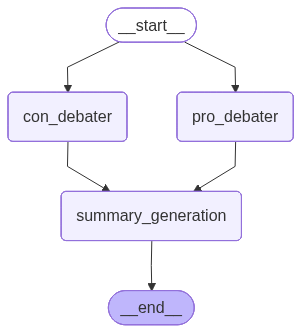

In [ ]:
workflow

In [ ]:
initial_state={'topic':"What do you think about Constrution of Road in Himalaya Mountain region"}

In [ ]:
response=workflow.invoke(initial_state)

In [ ]:
response

{'topic': 'What do you think about Constrution of Road in Himalaya Mountain region',
 'pro_response': "The construction of roads in the Himalaya mountain region is a contentious issue. While it may provide economic benefits and connectivity to remote areas, the risks far outweigh the gains.\n\nFirstly, the fragile ecosystem of the Himalayas is under immense pressure from human activity. Construction activities lead to soil erosion, landslides, and deforestation, which can have devastating consequences for the environment. The Himalayas are also home to numerous endangered species, and the construction of roads poses a significant threat to their survival.\n\nSecondly, the high altitude and rugged terrain of the Himalayas make construction a challenging and expensive process. The costs of building and maintaining roads in this region far exceed the benefits, making it a financially unsustainable endeavor.\n\nLastly, the construction of roads in the Himalayas will lead to an influx of to

## Conditional Workflows

In [ ]:
from pydantic import BaseModel,Field
from typing import Annotated

In [ ]:
class intent_classify(BaseModel):
  intent:Literal['billing','technical']=Field(description="Intent of the user Query")

In [ ]:
llm_structure1=llm.with_structured_output(intent_classify)

In [ ]:
llm_structure1.invoke("I was charged twice for my monthly subscription last week. Can you help me get a refund?")

intent_classify(intent='billing')

In [ ]:
class user_queries(TypedDict):
  topic:str
  query:str
  intent:Literal['billing','technical']
  billing_mail:str
  technical_mail:str
  # resolution:str


In [ ]:
def query_generation(state:user_queries):
  prompt=f"generate a sample query based on {state['topic']}"
  result=llm_parser.invoke(prompt)
  return {'query':result}

In [ ]:
def intent_classification(state:user_queries):
  prompt=f"""Based on the mentioned query classify the intent as either billing or technical only\n
  query:{state['query']}"""
  result=llm_structure1.invoke(prompt)
  return {'intent':result.intent}

In [ ]:
def check_query(state:user_queries):
  if state['intent']=='billing':
    return 'billing_query_node'
  else:
    return 'technical_query_node'

In [ ]:
def billing_query_node(state:user_queries):
  prompt=f"""You are a helpful customer support agent specializing in billing issues.
    The user has asked the following billing-related question:

    "{state['query']}"

    Respond in a friendly, professional, and empathetic tone.
    - Acknowledge their concern.
    - Explain what you can do to help.
    - If the query is unclear, politely ask for more details (e.g., invoice ID, date, amount).
    - Do NOT make promises about refunds or system changes you can't guarantee.
    - Keep the response under 3 sentences.
  """
  result=llm_parser.invoke(prompt)
  return {'billing_mail':result}

In [ ]:
def technical_query_node(state:user_queries):
  prompt = f"""You are a knowledgeable technical support engineer.
    The user has reported the following technical issue:

    "{state['query']}"

    Respond in a clear, calm, and solution-oriented tone.
    - Show understanding of the problem.
    - Offer a likely cause or first troubleshooting step.
    - If the issue is complex, suggest gathering more info (e.g., logs, error message, OS version).
    - Avoid jargon unless necessary; explain terms simply.
    - Keep it under 3 sentences."""
  result=llm_parser.invoke(prompt)
  return {'technical_mail':result}


In [ ]:
# define graph
graph=StateGraph(user_queries)

# add nodes
graph.add_node('query_generation',query_generation)
graph.add_node('intent_classification',intent_classification)
graph.add_node('billing_query_node',billing_query_node)
graph.add_node('technical_query_node',technical_query_node)
# graph.add_node('resolution_summary',resolution_summary)

# add edges
graph.add_edge(START,'query_generation')
graph.add_edge('query_generation','intent_classification')
# graph.add_edge('intent_classification',END)
graph.add_conditional_edges('intent_classification',check_query,{'billing_query_node':'billing_query_node','technical_query_node':'technical_query_node'})
graph.add_edge('technical_query_node',END)
graph.add_edge('billing_query_node',END)
# graph.add_edge('resolution_summary',END)

## compile
workflow=graph.compile()


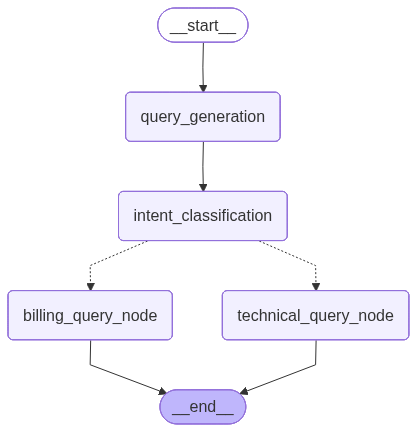

In [ ]:
workflow

In [ ]:
response=workflow.invoke({'topic':'I canceled my plan, but I still see a pending charge. '})

In [ ]:
response

{'topic': 'I canceled my plan, but I still see a pending charge. ',
 'query': "Here's a sample SQL query that can help identify pending charges after a plan has been canceled:\n\n**Table Structure**\n\nLet's assume we have the following table structure:\n\n```sql\nCREATE TABLE customers (\n    id INT PRIMARY KEY,\n    name VARCHAR(255),\n    plan_id INT\n);\n\nCREATE TABLE plans (\n    id INT PRIMARY KEY,\n    name VARCHAR(255),\n    price DECIMAL(10, 2)\n);\n\nCREATE TABLE transactions (\n    id INT PRIMARY KEY,\n    customer_id INT,\n    plan_id INT,\n    charge_date DATE,\n    amount DECIMAL(10, 2),\n    status VARCHAR(255)\n);\n```\n\n**Sample Query**\n\n```sql\nSELECT \n    c.id AS customer_id,\n    c.name AS customer_name,\n    p.name AS plan_name,\n    t.id AS transaction_id,\n    t.charge_date AS charge_date,\n    t.amount AS amount,\n    t.status AS transaction_status\nFROM \n    customers c\nJOIN \n    transactions t ON c.id = t.customer_id\nJOIN \n    plans p ON t.plan_id = 

In [ ]:
response['intent']

'technical'